## Analyze A/B Test Results

Made by: Asma AlReshoud

## Table of Contents

- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [46]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [47]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


c. The number of unique users in the dataset.

In [49]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [50]:
df.query('converted == 1').count()/df.count()

user_id         0.119659
timestamp       0.119659
group           0.119659
landing_page    0.119659
converted       0.119659
dtype: float64

e. The number of times the `new_page` and `treatment` don't line up.

In [51]:
treat = df.query('group == "treatment" and landing_page != "new_page"').count()
new = df.query('group != "treatment" and landing_page == "new_page"').count()

not_lined_up= treat+new
not_lined_up

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

f. Do any of the rows have missing values?

In [52]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [53]:
control = df.query('group == "control" and landing_page != "old_page"').count()
old = df.query('group != "control" and landing_page == "old_page"').count()

not_lined_up2= control+old
not_lined_up2

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

In [54]:
dropped = df.query('(group != "treatment" and landing_page == "new_page") or (group == "treatment" and landing_page != "new_page") or (group != "control" and landing_page == "old_page") or (group == "control" and landing_page != "old_page")')
df2 = df.drop(dropped.index)

In [55]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [56]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it? c. What is the row information for the repeat **user_id**? 

In [57]:
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [58]:
df2.drop(df2.query('user_id == 773192 and timestamp == "2017-01-09 05:37:58.781806"').index ,inplace = True)
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [59]:
len(df2.query('converted == 1'))/len(df2)

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [60]:
len(df2.query('converted == 1 and group == "control"'))/len(df2.query('group == "control"'))

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [61]:
len(df2.query('converted == 1 and group == "treatment"'))/len(df2.query('group == "treatment"'))

0.11880806551510564

d. What is the probability that an individual received the new page?

In [62]:
len(df2.query('landing_page == "new_page"'))/len(df2)

0.5000619442226688

e. Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions?  Write your response below.

based on the conducted probabilities, we can see that the probability of the individuals from the control group are more likely to convert than the treatment group, and the probability that an individual receives a new landing page is almost 50%.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

- H0: 𝑝𝑛𝑒𝑤 - 𝑝𝑜𝑙𝑑  <=0

- H1: 𝑝𝑛𝑒𝑤 - 𝑝𝑜𝑙𝑑  >0

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [63]:
p_new = len(df2.query('converted == 1'))/len(df2)
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [64]:
p_old = len(df2.query('converted == 1'))/len(df2)
p_old

0.11959708724499628

c. What is $n_{new}$?

In [65]:
n_new = len(df2.query('landing_page == "new_page"'))
n_new

145310

d. What is $n_{old}$?

In [66]:
n_old = len(df2.query('landing_page == "old_page"'))
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [67]:
new_page_converted = np.random.choice([1, 0], n_new, p_new)
new_page_converted

array([1, 1, 0, ..., 1, 0, 0])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [68]:
old_page_converted = np.random.choice([1, 0], n_old, p_old)
old_page_converted

array([0, 0, 0, ..., 0, 1, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [69]:
(new_page_converted.mean()) - (old_page_converted.mean())

0.0027805442726070995

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [70]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice([1, 0], n_new, p_new)
    new_page_converted = np.random.choice([1, 0], n_old, p_old)
    p_diffs.append((new_page_converted.mean()) - (old_page_converted.mean()))
np.array(p_diffs);

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

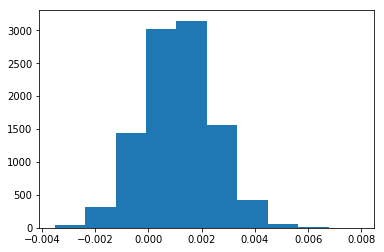

In [71]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [72]:
ab_mean = df2.converted.mean()

In [73]:
(p_diffs > ab_mean).mean()

0.0

In [74]:
(p_diffs < ab_mean).mean()

1.0

k. In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

Based on what we have studied in the vidoes, since the p value is 1 (which is greater that alpha) this means that we should move towards the null hypothesis, meaning that we accept the null hypothesis and reject the alternative with 𝑝𝑛𝑒𝑤 - 𝑝𝑜𝑙𝑑 >0.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [75]:
import statsmodels.api as sm

convert_old = len(df2.query('landing_page == "old_page" and converted == 1'))
convert_new = len(df2.query('landing_page == "new_page" and converted == 1'))
n_old = len(df2.query('landing_page == "old_page"'))
n_new = len(df2.query('landing_page == "new_page"'))

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [76]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old])
print(z_score)
print(p_value)

-1.31092419842
0.189883374482


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

Since the z-score of -1.31092419842 is lower than 0.189883374482, the null hypothesis should be accepted that there is no significant diffrenece between the old and new page.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Logistic Regrission as what we saw in the videos 

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a colun for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [86]:
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df.group) ['treatment']
df2

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [91]:
logit = sm.Logit(df2['converted'],df2[['intercept','ab_page']])

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [92]:
res = logit.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 08 Feb 2019   Pseudo R-squ.:               8.077e-06
Time:                        19:21:12   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?

Since the P value of ab_page is 0.19 which is clearly greater that 0.05 (type 1 error) (P < 0.05) which proves that the landing page is not statisticlly significant. The H0 and H1 are:
- H0: 𝑝𝑛𝑒𝑤 - 𝑝𝑜𝑙𝑑 = 0
- H1: 𝑝𝑛𝑒𝑤 - 𝑝𝑜𝑙𝑑 != 0

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

Adding the country and timestamp could be helpful, but it would make the model complex.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy varaibles.** Provide the statistical output as well as a written response to answer this question.

In [95]:
con_df = pd.read_csv('countries.csv')
con_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


Since this dataset include a matching column (user id) we can merge them with it.

In [97]:
joined_df = df2.set_index('user_id').join(con_df.set_index('user_id'))
joined_df

,timestamp,group,landing_page,converted,intercept,ab_page,country
user_id,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US
936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0,US
679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA
719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0,US
817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK


In [98]:
joined_df.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

Since there is only three variables let's seperate them into dummy column

In [102]:
joined_df[['CA','UK', 'US']] = pd.get_dummies(joined_df.country)
joined_df

,timestamp,group,landing_page,converted,intercept,ab_page,country,UK,CA,US
user_id,,,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1
936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0,US,0,0,1
679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA,0,1,0
719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0,US,0,0,1
817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK,1,0,0


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [105]:
logit2 = sm.Logit(joined_df['converted'], joined_df[['intercept', 'US', 'CA']])
res2 = logit2.fit()
res2.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Fri, 08 Feb 2019   Pseudo R-squ.:               1.521e-05
Time:                        19:56:14   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9868      0.011   -174.174      0.000      -2.009      -1.964
US            -0.0099      0.013     -0.746      0.456      -0.036       0.016
CA            -0.0507      0.028     -1.786      0.074      -0.106       0.005
==============================================================================
"""

Since both P values are less than type 1 errer no signifficant impact appears

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  This is the final project in Term 1.  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [106]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0

# references:
- https://stackoverflow.com/questions/14657241/how-do-i-get-a-list-of-all-the-duplicate-items-using-pandas-in-python
- https://www.statsdirect.com/help/basics/p_values.htm
- http://knowledgetack.com/python/statsmodels/proportions_ztest/
- https://www.khanacademy.org/math/ap-statistics/tests-significance-ap/one-sample-t-test-mean/e/p-value-t-test-mean
- https://stackoverflow.com/questions/11587782/creating-dummy-variables-in-pandas-for-python
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html